In [1]:
import pandas as pd
import keras
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 9,6

from keras.datasets import cifar10

from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, MaxPool2D, BatchNormalization, GlobalAveragePooling2D, UpSampling2D
from keras.layers.advanced_activations import LeakyReLU

from keras import backend as K
from keras import applications
from keras import callbacks
from keras import optimizers
from keras.utils import np_utils
import random
from sklearn.metrics import accuracy_score
import tensorflow as tf
import tensorflow_addons as tfa

from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings(action='ignore')

2022-04-08 16:34:52.048524: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-08 16:34:52.048545: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# <span style='font-family:Georgia'> Data loading & preparation

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

BATCH_SIZE = 32
INPUT_SHAPE = X_train.shape[1:]
NUM_CLASSES=10

print('x_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


In [3]:
# Normalize input data
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

# Convert class labels to one-hot encoded
y_train = keras.utils.np_utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.np_utils.to_categorical(y_test, NUM_CLASSES)

# <span style='font-family:Georgia'> Fitting the Deep Learning Models

In [4]:
LR=1e-3 # chosen base on tuning performed in the modelling notebook
EPOCHS=100
PATIENCE=10
MIN_DELTA=0.01
early_stop = EarlyStopping(monitor='val_accuracy', patience=PATIENCE, min_delta=MIN_DELTA)

In [5]:
# Data augmentation - 2 different approaches

datagen1 = ImageDataGenerator(
    zca_epsilon=1e-06,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2
)
datagen1.fit(X_train)

datagen2 = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)
datagen2.fit(X_train)

## <span style='font-family:Georgia'> Model concept no. 1

In [6]:
def generate_model1(learning_rate: float = LR):
    """
    Generate Keras Sequential model according to proposed architecture (1).

    Args:
        learning_rate (float, optional): Learning rate of the neural network. Defaults to LR.

    Returns:
        Keras Sequential model, complied, ready to use (to call .fit method).
    """

    model = Sequential()

    model.add(Conv2D(filters = 16, kernel_size = (3, 3), padding='same', input_shape=INPUT_SHAPE))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Activation("softmax"))
    
    model.compile(
        loss='categorical_crossentropy',  
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, decay=1e-6), 
        metrics=['accuracy']
    )
    
    return model

In [7]:
model1_stats = []
model1_aug1_stats = []
model1_aug2_stats = []
model1_acc = []
model1_aug1_acc = []
model1_aug2_acc = []
for i in range(5):
    print('iteration: '+str(i))
    model1 = generate_model1()
    model1_history = (model1.fit(X_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,
        callbacks=[early_stop],shuffle=True,verbose=1,validation_data=(X_test, y_test_ohe)))
    model1_stats.append(model1_history)

    model1_aug1 = generate_model1()
    model1_aug1_history = (model1_aug1.fit(datagen1.flow(X_train, y_train, batch_size=BATCH_SIZE),
        epochs=EPOCHS,validation_data=(X_test, y_test_ohe),callbacks=[early_stop],workers=4,verbose=1))
    model1_aug1_stats.append(model1_aug1_history)
    
    model1_aug2 = generate_model1()
    model1_aug2_history = (model1_aug2.fit(datagen2.flow(X_train, y_train, batch_size=BATCH_SIZE),
        epochs=EPOCHS,validation_data=(X_test, y_test_ohe),callbacks=[early_stop],workers=4,verbose=1)) 
    model1_aug2_stats.append(model1_aug2_history)

    y_pred_1 = model1.predict(X_test)
    y_pred_1_aug1 = model1_aug1.predict(X_test)
    y_pred_1_aug2 = model1_aug2.predict(X_test)
    y_pred_classes_1 = np.argmax(y_pred_1, axis=-1)
    y_pred_classes_1_aug1 = np.argmax(y_pred_1_aug1, axis=-1)
    y_pred_classes_1_aug2 = np.argmax(y_pred_1_aug2, axis=-1)
    model1_acc.append(accuracy_score(y_test, y_pred_classes_1))
    model1_aug1_acc.append(accuracy_score(y_test, y_pred_classes_1_aug1))
    model1_aug2_acc.append(accuracy_score(y_test, y_pred_classes_1_aug2))


iteration: 0


2022-04-08 16:35:03.636190: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-08 16:35:03.636212: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-08 16:35:03.636229: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: agatamakarewicz-Legion-Y540-15IRH
2022-04-08 16:35:03.636235: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: agatamakarewicz-Legion-Y540-15IRH
2022-04-08 16:35:03.636295: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2022-04-08 16:35:03.636329: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.54.0
2022-04-08 16:35:03.636533: I tensorflow/cor

Epoch 1/100
1563/1563 [==============================] - 55s 35ms/step - loss: 1.4045 - accuracy: 0.4914 - val_loss: 1.0159 - val_accuracy: 0.6419
Epoch 2/100
1563/1563 [==============================] - 60s 38ms/step - loss: 0.9760 - accuracy: 0.6582 - val_loss: 0.8918 - val_accuracy: 0.6845
Epoch 3/100
1563/1563 [==============================] - 59s 38ms/step - loss: 0.8444 - accuracy: 0.7035 - val_loss: 0.7689 - val_accuracy: 0.7306
Epoch 4/100
1563/1563 [==============================] - 60s 38ms/step - loss: 0.7607 - accuracy: 0.7329 - val_loss: 0.7315 - val_accuracy: 0.7436
Epoch 5/100
1563/1563 [==============================] - 59s 38ms/step - loss: 0.7037 - accuracy: 0.7532 - val_loss: 0.6935 - val_accuracy: 0.7603
Epoch 6/100
1563/1563 [==============================] - 60s 38ms/step - loss: 0.6614 - accuracy: 0.7672 - val_loss: 0.6493 - val_accuracy: 0.7721
Epoch 7/100
1563/1563 [==============================] - 60s 38ms/step - loss: 0.6272 - accuracy: 0.7791 - val_loss: 0

1563/1563 [==============================] - 60s 38ms/step - loss: 1.6861 - accuracy: 0.3769 - val_loss: 1.3316 - val_accuracy: 0.5213
Epoch 2/100
1563/1563 [==============================] - 59s 38ms/step - loss: 1.3723 - accuracy: 0.5043 - val_loss: 1.2256 - val_accuracy: 0.5691
Epoch 3/100
1563/1563 [==============================] - 59s 38ms/step - loss: 1.2418 - accuracy: 0.5543 - val_loss: 1.0858 - val_accuracy: 0.6128
Epoch 4/100
1563/1563 [==============================] - 59s 38ms/step - loss: 1.1697 - accuracy: 0.5808 - val_loss: 1.0681 - val_accuracy: 0.6196
Epoch 5/100
1563/1563 [==============================] - 60s 38ms/step - loss: 1.1213 - accuracy: 0.6008 - val_loss: 1.0785 - val_accuracy: 0.6278
Epoch 6/100
1563/1563 [==============================] - 60s 38ms/step - loss: 1.0926 - accuracy: 0.6120 - val_loss: 1.1866 - val_accuracy: 0.5984
Epoch 7/100
1563/1563 [==============================] - 60s 38ms/step - loss: 1.0562 - accuracy: 0.6252 - val_loss: 0.9812 - val_

1563/1563 [==============================] - 64s 41ms/step - loss: 1.0226 - accuracy: 0.6408 - val_loss: 0.8019 - val_accuracy: 0.7135
Epoch 13/100
1563/1563 [==============================] - 63s 40ms/step - loss: 1.0109 - accuracy: 0.6452 - val_loss: 0.8767 - val_accuracy: 0.7044
Epoch 14/100
1563/1563 [==============================] - 61s 39ms/step - loss: 1.0086 - accuracy: 0.6452 - val_loss: 0.8611 - val_accuracy: 0.6916
Epoch 15/100
1563/1563 [==============================] - 64s 41ms/step - loss: 0.9922 - accuracy: 0.6526 - val_loss: 0.8595 - val_accuracy: 0.7196
Epoch 16/100
1563/1563 [==============================] - 64s 41ms/step - loss: 0.9798 - accuracy: 0.6561 - val_loss: 0.8194 - val_accuracy: 0.7162
Epoch 17/100
1563/1563 [==============================] - 63s 40ms/step - loss: 0.9830 - accuracy: 0.6572 - val_loss: 0.8219 - val_accuracy: 0.7180
Epoch 18/100
1563/1563 [==============================] - 61s 39ms/step - loss: 0.9723 - accuracy: 0.6606 - val_loss: 0.9065 

1563/1563 [==============================] - 59s 38ms/step - loss: 0.5046 - accuracy: 0.8207 - val_loss: 0.6265 - val_accuracy: 0.7940
Epoch 14/100
1563/1563 [==============================] - 60s 38ms/step - loss: 0.4879 - accuracy: 0.8286 - val_loss: 0.6192 - val_accuracy: 0.7958
Epoch 15/100
1563/1563 [==============================] - 60s 38ms/step - loss: 0.4759 - accuracy: 0.8318 - val_loss: 0.6431 - val_accuracy: 0.7905
Epoch 16/100
1563/1563 [==============================] - 60s 38ms/step - loss: 0.4695 - accuracy: 0.8339 - val_loss: 0.6390 - val_accuracy: 0.7913
Epoch 17/100
1563/1563 [==============================] - 59s 38ms/step - loss: 0.4584 - accuracy: 0.8375 - val_loss: 0.6880 - val_accuracy: 0.7819
Epoch 18/100
1563/1563 [==============================] - 60s 38ms/step - loss: 0.4483 - accuracy: 0.8405 - val_loss: 0.6631 - val_accuracy: 0.7914
Epoch 19/100
1563/1563 [==============================] - 60s 38ms/step - loss: 0.4404 - accuracy: 0.8428 - val_loss: 0.6521 

1563/1563 [==============================] - 63s 41ms/step - loss: 0.9003 - accuracy: 0.6869 - val_loss: 0.6771 - val_accuracy: 0.7724
Epoch 40/100
1563/1563 [==============================] - 64s 41ms/step - loss: 0.8860 - accuracy: 0.6918 - val_loss: 0.8146 - val_accuracy: 0.7401
Epoch 41/100
1563/1563 [==============================] - 60s 38ms/step - loss: 0.8849 - accuracy: 0.6911 - val_loss: 0.7305 - val_accuracy: 0.7511
Epoch 1/100
1563/1563 [==============================] - 60s 38ms/step - loss: 1.7028 - accuracy: 0.3692 - val_loss: 1.3800 - val_accuracy: 0.4931
Epoch 2/100
1563/1563 [==============================] - 60s 38ms/step - loss: 1.3833 - accuracy: 0.4988 - val_loss: 1.2203 - val_accuracy: 0.5633
Epoch 3/100
1563/1563 [==============================] - 60s 38ms/step - loss: 1.2557 - accuracy: 0.5442 - val_loss: 1.1118 - val_accuracy: 0.6034
Epoch 4/100
1563/1563 [==============================] - 60s 38ms/step - loss: 1.1825 - accuracy: 0.5754 - val_loss: 1.0617 - va

1563/1563 [==============================] - 60s 38ms/step - loss: 1.2897 - accuracy: 0.5369 - val_loss: 0.9961 - val_accuracy: 0.6418
Epoch 4/100
1563/1563 [==============================] - 64s 41ms/step - loss: 1.2206 - accuracy: 0.5661 - val_loss: 1.0377 - val_accuracy: 0.6308
Epoch 5/100
1563/1563 [==============================] - 64s 41ms/step - loss: 1.1715 - accuracy: 0.5867 - val_loss: 0.9739 - val_accuracy: 0.6548
Epoch 6/100
1563/1563 [==============================] - 65s 42ms/step - loss: 1.1341 - accuracy: 0.5984 - val_loss: 0.9835 - val_accuracy: 0.6597
Epoch 7/100
1563/1563 [==============================] - 60s 38ms/step - loss: 1.1044 - accuracy: 0.6123 - val_loss: 1.0905 - val_accuracy: 0.6344
Epoch 8/100
1563/1563 [==============================] - 64s 41ms/step - loss: 1.0875 - accuracy: 0.6156 - val_loss: 0.9995 - val_accuracy: 0.6568
Epoch 9/100
1563/1563 [==============================] - 65s 42ms/step - loss: 1.0640 - accuracy: 0.6266 - val_loss: 0.8567 - val_

1563/1563 [==============================] - 60s 38ms/step - loss: 0.9269 - accuracy: 0.6712 - val_loss: 0.8509 - val_accuracy: 0.7156
Epoch 21/100
1563/1563 [==============================] - 60s 38ms/step - loss: 0.9169 - accuracy: 0.6779 - val_loss: 0.8625 - val_accuracy: 0.7140
Epoch 22/100
1563/1563 [==============================] - 60s 38ms/step - loss: 0.9154 - accuracy: 0.6775 - val_loss: 1.0109 - val_accuracy: 0.6607
Epoch 23/100
1563/1563 [==============================] - 63s 40ms/step - loss: 0.9115 - accuracy: 0.6786 - val_loss: 0.8531 - val_accuracy: 0.7051
Epoch 24/100
1563/1563 [==============================] - 65s 41ms/step - loss: 0.9010 - accuracy: 0.6831 - val_loss: 0.9071 - val_accuracy: 0.6942
Epoch 25/100
1563/1563 [==============================] - 64s 41ms/step - loss: 0.8997 - accuracy: 0.6836 - val_loss: 0.8186 - val_accuracy: 0.7203
Epoch 26/100
1563/1563 [==============================] - 65s 41ms/step - loss: 0.8987 - accuracy: 0.6853 - val_loss: 0.8491 

1563/1563 [==============================] - 65s 41ms/step - loss: 0.9472 - accuracy: 0.6685 - val_loss: 0.7345 - val_accuracy: 0.7467
Epoch 25/100
1563/1563 [==============================] - 65s 41ms/step - loss: 0.9406 - accuracy: 0.6710 - val_loss: 0.8637 - val_accuracy: 0.7108
Epoch 26/100
1563/1563 [==============================] - 60s 39ms/step - loss: 0.9391 - accuracy: 0.6726 - val_loss: 0.8881 - val_accuracy: 0.7124
Epoch 27/100
1563/1563 [==============================] - 64s 41ms/step - loss: 0.9319 - accuracy: 0.6729 - val_loss: 0.8116 - val_accuracy: 0.7266
Epoch 1/100
1563/1563 [==============================] - 60s 38ms/step - loss: 1.7071 - accuracy: 0.3697 - val_loss: 1.3079 - val_accuracy: 0.5222
Epoch 2/100
1563/1563 [==============================] - 60s 38ms/step - loss: 1.3680 - accuracy: 0.5081 - val_loss: 1.2255 - val_accuracy: 0.5597
Epoch 3/100
1563/1563 [==============================] - 60s 38ms/step - loss: 1.2502 - accuracy: 0.5495 - val_loss: 1.1733 - v

1563/1563 [==============================] - 59s 38ms/step - loss: 0.8485 - accuracy: 0.7029 - val_loss: 0.7870 - val_accuracy: 0.7309
Epoch 53/100
1563/1563 [==============================] - 59s 38ms/step - loss: 0.8391 - accuracy: 0.7052 - val_loss: 0.8891 - val_accuracy: 0.7074
Epoch 54/100
1563/1563 [==============================] - 59s 38ms/step - loss: 0.8404 - accuracy: 0.7044 - val_loss: 0.8410 - val_accuracy: 0.7220


### <span style='font-family:Georgia'> Model no 1. results summary

In [16]:
model1_acc_results = pd.DataFrame([model1_acc, model1_aug1_acc, model1_aug2_acc]).T
model1_acc_results.columns=['model1', 'model1_aug1', 'model1_aug2']
model1_acc_results_stats = model1_acc_results.describe().T[['mean', 'std', 'min', 'max']]

In [20]:
model1_epochs = []
model1_aug1_epochs = []
model1_aug2_epochs = []
for i in range(5):
    model1_epochs.append(len(model1_stats[i].history['loss']))
    model1_aug1_epochs.append(len(model1_aug1_stats[i].history['loss']))
    model1_aug2_epochs.append(len(model1_aug2_stats[i].history['loss']))
model1_acc_results_stats['epochs'] = [np.array(model1_epochs).mean(), np.array(model1_aug1_epochs).mean(),
                                      np.array(model1_aug2_epochs).mean()]
model1_acc_results_stats

,mean,std,min,max,epochs
model1,0.79860,0.003415,0.7953,0.8043,25.8
model1_aug1,0.72878,0.014800,0.7147,0.7511,32.6
model1_aug2,0.70824,0.018683,0.6907,0.7327,30.2


## <span style='font-family:Georgia'> Model concept no. 2

In [21]:
def generate_model2(learning_rate: float = LR):
    """
    Generate Keras Sequential model according to proposed architecture (2).

    Args:
        learning_rate (float, optional): Learning rate of the neural network. Defaults to LR.

    Returns:
        Keras Sequential model, complied, ready to use (to call .fit method).
    """

    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=INPUT_SHAPE, activation='relu', padding = 'same', kernel_initializer='he_uniform'))
    model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=INPUT_SHAPE, activation='relu', padding = 'same', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=INPUT_SHAPE, activation='relu', padding = 'same', kernel_initializer='he_uniform'))
    model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=INPUT_SHAPE, activation='relu', padding = 'same', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(filters=128, kernel_size=(3,3), input_shape=INPUT_SHAPE, activation='relu', padding = 'same', kernel_initializer='he_uniform'))
    model.add(Conv2D(filters=128, kernel_size=(3,3), input_shape=INPUT_SHAPE, activation='relu', padding = 'same', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.4))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, decay=1e-6), 
              metrics=['accuracy'])
    
    return model    

In [ ]:
model2_stats = []
model2_aug1_stats = []
model2_aug2_stats = []
model2_acc = []
model2_aug1_acc = []
model2_aug2_acc = []
for i in range(5):
    print('iteration: '+str(i))
    model2 = generate_model2()
    model2_history = (model2.fit(X_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,
        callbacks=[early_stop],shuffle=True,verbose=1,validation_data=(X_test, y_test_ohe)))
    model2_stats.append(model2_history)
    model2_aug1 = generate_model2()
    model2_aug1_history = (model2_aug1.fit(datagen1.flow(X_train, y_train, batch_size=BATCH_SIZE),
        epochs=EPOCHS,validation_data=(X_test, y_test_ohe),callbacks=[early_stop],workers=4,verbose=1))
    model2_aug1_stats.append(model2_aug1_history)
    model2_aug2 = generate_model2()
    model2_aug2_history = (model2_aug2.fit(datagen2.flow(X_train, y_train, batch_size=BATCH_SIZE),
        epochs=EPOCHS,validation_data=(X_test, y_test_ohe),callbacks=[early_stop],workers=4,verbose=1)) 
    model2_aug2_stats.append(model2_aug2_history)         

    y_pred_2 = model2.predict(X_test)
    y_pred_2_aug1 = model2_aug1.predict(X_test)
    y_pred_2_aug2 = model2_aug2.predict(X_test)
    y_pred_classes_2 = np.argmax(y_pred_2, axis=-1)
    y_pred_classes_2_aug1 = np.argmax(y_pred_2_aug1, axis=-1)
    y_pred_classes_2_aug2 = np.argmax(y_pred_2_aug2, axis=-1)
    model2_acc.append(accuracy_score(y_test, y_pred_classes_2))
    model2_aug1_acc.append(accuracy_score(y_test, y_pred_classes_2_aug1))
    model2_aug2_acc.append(accuracy_score(y_test, y_pred_classes_2_aug2))


iteration: 0
Epoch 1/100
1563/1563 [==============================] - 104s 66ms/step - loss: 1.7843 - accuracy: 0.3395 - val_loss: 1.4797 - val_accuracy: 0.4685
Epoch 2/100
1563/1563 [==============================] - 104s 66ms/step - loss: 1.3325 - accuracy: 0.5179 - val_loss: 1.0932 - val_accuracy: 0.6139
Epoch 3/100
1563/1563 [==============================] - 104s 66ms/step - loss: 1.1161 - accuracy: 0.6051 - val_loss: 0.9569 - val_accuracy: 0.6661
Epoch 4/100
1563/1563 [==============================] - 104s 66ms/step - loss: 0.9874 - accuracy: 0.6534 - val_loss: 0.8740 - val_accuracy: 0.6895
Epoch 5/100
1563/1563 [==============================] - 104s 66ms/step - loss: 0.8991 - accuracy: 0.6873 - val_loss: 0.7628 - val_accuracy: 0.7309
Epoch 6/100
1563/1563 [==============================] - 104s 66ms/step - loss: 0.8284 - accuracy: 0.7113 - val_loss: 0.6871 - val_accuracy: 0.7605
Epoch 7/100
1563/1563 [==============================] - 113s 72ms/step - loss: 0.7780 - accuracy: 

1563/1563 [==============================] - 107s 68ms/step - loss: 0.9501 - accuracy: 0.6714 - val_loss: 0.9644 - val_accuracy: 0.6849
Epoch 15/100
1563/1563 [==============================] - 108s 69ms/step - loss: 0.9323 - accuracy: 0.6805 - val_loss: 0.9431 - val_accuracy: 0.6925
Epoch 16/100
1563/1563 [==============================] - 108s 69ms/step - loss: 0.9118 - accuracy: 0.6848 - val_loss: 0.9461 - val_accuracy: 0.7013
Epoch 17/100
1563/1563 [==============================] - 108s 69ms/step - loss: 0.8855 - accuracy: 0.6941 - val_loss: 0.7749 - val_accuracy: 0.7389
Epoch 18/100
1563/1563 [==============================] - 108s 69ms/step - loss: 0.8750 - accuracy: 0.6969 - val_loss: 0.8005 - val_accuracy: 0.7346
Epoch 19/100
1563/1563 [==============================] - 108s 69ms/step - loss: 0.8634 - accuracy: 0.7035 - val_loss: 0.8002 - val_accuracy: 0.7424
Epoch 20/100
1563/1563 [==============================] - 108s 69ms/step - loss: 0.8450 - accuracy: 0.7099 - val_loss: 

1563/1563 [==============================] - 108s 69ms/step - loss: 0.7459 - accuracy: 0.7398 - val_loss: 0.6974 - val_accuracy: 0.7743
Epoch 34/100
1563/1563 [==============================] - 107s 69ms/step - loss: 0.7473 - accuracy: 0.7388 - val_loss: 0.7171 - val_accuracy: 0.7588
Epoch 35/100
1563/1563 [==============================] - 108s 69ms/step - loss: 0.7364 - accuracy: 0.7427 - val_loss: 0.6853 - val_accuracy: 0.7658
Epoch 36/100
1563/1563 [==============================] - 108s 69ms/step - loss: 0.7307 - accuracy: 0.7471 - val_loss: 0.6472 - val_accuracy: 0.7802
Epoch 37/100
1563/1563 [==============================] - 108s 69ms/step - loss: 0.7272 - accuracy: 0.7466 - val_loss: 0.6280 - val_accuracy: 0.7841
Epoch 38/100
1563/1563 [==============================] - 108s 69ms/step - loss: 0.7233 - accuracy: 0.7489 - val_loss: 0.6608 - val_accuracy: 0.7741
Epoch 39/100
1563/1563 [==============================] - 107s 69ms/step - loss: 0.7287 - accuracy: 0.7476 - val_loss: 

1563/1563 [==============================] - 109s 69ms/step - loss: 1.0627 - accuracy: 0.6307 - val_loss: 1.1273 - val_accuracy: 0.6337
Epoch 11/100
1563/1563 [==============================] - 108s 69ms/step - loss: 1.0234 - accuracy: 0.6461 - val_loss: 1.0702 - val_accuracy: 0.6586
Epoch 12/100
1563/1563 [==============================] - 107s 68ms/step - loss: 1.0091 - accuracy: 0.6512 - val_loss: 1.0136 - val_accuracy: 0.6753
Epoch 13/100
1563/1563 [==============================] - 108s 69ms/step - loss: 0.9788 - accuracy: 0.6610 - val_loss: 0.8941 - val_accuracy: 0.7047
Epoch 14/100
1563/1563 [==============================] - 108s 69ms/step - loss: 0.9526 - accuracy: 0.6695 - val_loss: 0.8159 - val_accuracy: 0.7252
Epoch 15/100
1563/1563 [==============================] - 108s 69ms/step - loss: 0.9369 - accuracy: 0.6782 - val_loss: 0.9698 - val_accuracy: 0.6954
Epoch 16/100
1563/1563 [==============================] - 108s 69ms/step - loss: 0.9141 - accuracy: 0.6837 - val_loss: 

1563/1563 [==============================] - 107s 68ms/step - loss: 0.8511 - accuracy: 0.7002 - val_loss: 0.7610 - val_accuracy: 0.7318
Epoch 21/100
1563/1563 [==============================] - 107s 68ms/step - loss: 0.8411 - accuracy: 0.7062 - val_loss: 0.8080 - val_accuracy: 0.7242
Epoch 22/100
1563/1563 [==============================] - 107s 68ms/step - loss: 0.8329 - accuracy: 0.7094 - val_loss: 0.8421 - val_accuracy: 0.7183
Epoch 23/100
1563/1563 [==============================] - 107s 68ms/step - loss: 0.8244 - accuracy: 0.7138 - val_loss: 0.7500 - val_accuracy: 0.7414
Epoch 24/100
1563/1563 [==============================] - 107s 68ms/step - loss: 0.8139 - accuracy: 0.7150 - val_loss: 0.7381 - val_accuracy: 0.7470
Epoch 25/100
1563/1563 [==============================] - 107s 68ms/step - loss: 0.8117 - accuracy: 0.7171 - val_loss: 0.9499 - val_accuracy: 0.6994
Epoch 26/100
1563/1563 [==============================] - 107s 68ms/step - loss: 0.8048 - accuracy: 0.7189 - val_loss: 

1563/1563 [==============================] - 113s 72ms/step - loss: 0.3467 - accuracy: 0.8769 - val_loss: 0.5075 - val_accuracy: 0.8432
Epoch 34/100
1563/1563 [==============================] - 113s 72ms/step - loss: 0.3401 - accuracy: 0.8812 - val_loss: 0.5006 - val_accuracy: 0.8433
Epoch 1/100
1563/1563 [==============================] - 120s 76ms/step - loss: 1.9525 - accuracy: 0.2675 - val_loss: 1.6653 - val_accuracy: 0.3743
Epoch 2/100
1563/1563 [==============================] - 118s 75ms/step - loss: 1.6675 - accuracy: 0.3821 - val_loss: 1.9112 - val_accuracy: 0.3835
Epoch 3/100
1563/1563 [==============================] - 118s 76ms/step - loss: 1.5223 - accuracy: 0.4437 - val_loss: 1.6106 - val_accuracy: 0.4445
Epoch 4/100
1563/1563 [==============================] - 117s 75ms/step - loss: 1.4140 - accuracy: 0.4913 - val_loss: 1.4890 - val_accuracy: 0.4877
Epoch 5/100
1563/1563 [==============================] - 118s 75ms/step - loss: 1.3209 - accuracy: 0.5297 - val_loss: 1.049

### <span style='font-family:Georgia'> Model no 2. results summary

In [ ]:
model2_acc_results = pd.DataFrame([model2_acc, model2_aug1_acc, model2_aug2_acc]).T
model2_acc_results.columns=['model2', 'model2_aug1', 'model2_aug2']
model2_acc_results_stats = model2_acc_results.describe().T[['mean', 'std', 'min', 'max']]

In [ ]:
model2_epochs = []
model2_aug1_epochs = []
model2_aug2_epochs = []
for i in range(5):
    model2_epochs.append(len(model2_stats[i].history['loss']))
    model2_aug1_epochs.append(len(model2_aug1_stats[i].history['loss']))
    model2_aug2_epochs.append(len(model2_aug2_stats[i].history['loss']))
model2_acc_results_stats['epochs'] = [np.array(model2_epochs).mean(), np.array(model2_aug1_epochs).mean(),
                                      np.array(model2_aug2_epochs).mean()]
model2_acc_results_stats

## <span style='font-family:Georgia'> Model concept no. 3

In [20]:
def generate_model3(learning_rate: float = LR):
    """
    Generate Keras Sequential model according to proposed architecture (3).

    Args:
        learning_rate (float, optional): Learning rate of the neural network. Defaults to LR.

    Returns:
        Keras Sequential model, complied, ready to use (to call .fit method).
    """

    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(4,4), input_shape=INPUT_SHAPE, activation='relu',))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=32, kernel_size=(4,4), activation='relu',))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, decay=1e-6), 
               metrics=['accuracy'])
    
    return model

In [ ]:
model3_stats = []
model3_aug1_stats = []
model3_aug2_stats = []
model3_acc = []
model3_aug1_acc = []
model3_aug2_acc = []
for i in range(5):
    print('iteration: '+str(i))
    model3 = generate_model3()
    model3_history = (model3.fit(X_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,
        callbacks=[early_stop],shuffle=True,verbose=1,validation_data=(X_test, y_test_ohe)))
    model3_stats.append(model3_history)
    model3_aug1 = generate_model3()
    model3_aug1_history = (model3_aug1.fit(datagen1.flow(X_train, y_train, batch_size=BATCH_SIZE),
        epochs=EPOCHS,validation_data=(X_test, y_test_ohe),callbacks=[early_stop],workers=4,verbose=1))
    model3_aug1_stats.append(model3_aug1_history)
    model3_aug2 = generate_model3()
    model3_aug2_history = (model3_aug2.fit(datagen2.flow(X_train, y_train, batch_size=BATCH_SIZE),
        epochs=EPOCHS,validation_data=(X_test, y_test_ohe),callbacks=[early_stop],workers=4,verbose=1)) 
    model3_aug2_stats.append(model3_aug2_history)         

    y_pred_3 = model3.predict(X_test)
    y_pred_3_aug1 = model3_aug1.predict(X_test)
    y_pred_3_aug2 = model3_aug2.predict(X_test)
    y_pred_classes_3 = np.argmax(y_pred_3, axis=-1)
    y_pred_classes_3_aug1 = np.argmax(y_pred_3_aug1, axis=-1)
    y_pred_classes_3_aug2 = np.argmax(y_pred_3_aug2, axis=-1)
    model3_acc.append(accuracy_score(y_test, y_pred_classes_3))
    model3_aug1_acc.append(accuracy_score(y_test, y_pred_classes_3_aug1))
    model3_aug2_acc.append(accuracy_score(y_test, y_pred_classes_3_aug2))

### <span style='font-family:Georgia'> Model no. 3 results summary

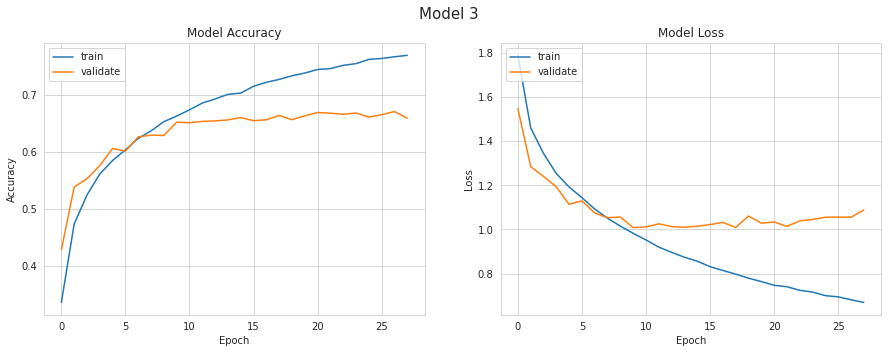

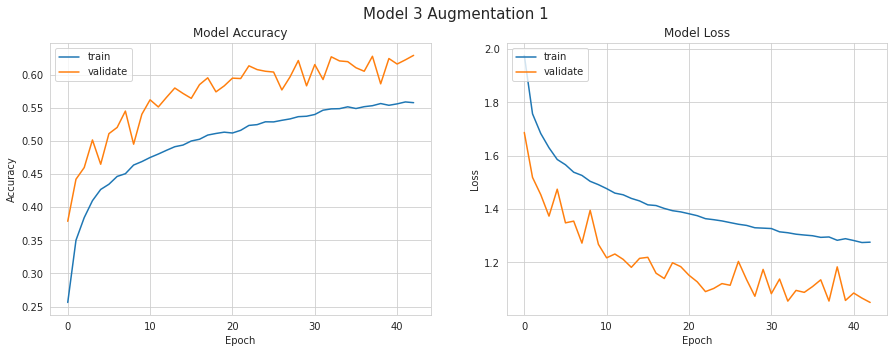

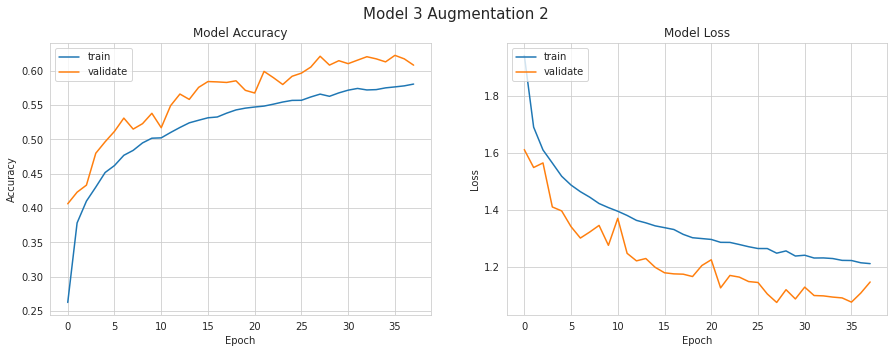

In [25]:
model3_acc_results = pd.DataFrame([model3_acc, model3_aug1_acc, model3_aug2_acc]).T
model3_acc_results.columns=['model3', 'model3_aug1', 'model3_aug2']
model3_acc_results_stats = model3_acc_results.describe().T[['mean', 'std', 'min', 'max']]

In [ ]:
model3_epochs = []
model3_aug1_epochs = []
model3_aug2_epochs = []
for i in range(5):
    model3_epochs.append(len(model3_stats[i].history['loss']))
    model3_aug1_epochs.append(len(model3_aug1_stats[i].history['loss']))
    model3_aug2_epochs.append(len(model3_aug2_stats[i].history['loss']))
model3_acc_results_stats['epochs'] = [np.array(model3_epochs).mean(), np.array(model3_aug1_epochs).mean(),
                                      np.array(model3_aug2_epochs).mean()]
model3_acc_results_stats